# Implement Hessian Loss Landscapes

Ashley S. Dale

Notebook loads a pretrained ALIGNN model, and calculates the loss landscape using Hessian directions


- Relevant paper: [*Visualizing high-dimensional loss landscapes with Hessian directions* by Bottcher and Wheeler](https://iopscience.iop.org/article/10.1088/1742-5468/ad13fc/meta)

---
Notebook Outline:

0. Select and load trained model and data

0. Generate a set of predictions for the data

0. Select a subset of well predicted instances to be "In Distribution" (ID) based on the z-score of the prediction error, where low z-score represents well predicted and therefore in-distribution

0. Select a subset of poorly predicted instances to be "Out of Distribution" (OOD) based on the z-score of the prediction error, where a high z-score represents poorly predicted and therefore out-of-distribution

0. Calculate the eigenvectors of the model's Hessian using the Hessian Vector Product

0. Format two of the Hessians as two new models. These models will define the coordinate axes of the loss landscape

0. Calculate the loss landscape using the original model as the origin, and the models generated from the eigenvectors of the Hessian as the two directions in which the original model is perturbed. Repeat this twice for the ID and OOD datasets.


In [1]:
import copy
import torch
import glob
import json

import numpy as np
from tqdm import tqdm
# import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

import ipywidgets as widgets
from torchinfo import summary
from pymatgen.core.periodic_table import Element
from collections import OrderedDict

import alignn
from alignn.pretrained import *
from jarvis.db.figshare import data
from jarvis.db.figshare import data
from jarvis.db.jsonutils import loadjson

import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod

from src.utils import *

In [2]:
if torch. cuda. is_available():
    print("Using GPU ...")
    device = 'cuda'
else:
    device = 'cpu'

Using GPU ...


# Load Model

In [3]:
list_of_pretrained_models = list(get_all_models().keys())

-> Select the `jv_formation_energy_peratom_alignn` model for the demo

In [4]:
style = {'description_width': 'initial'}

config_selector = widgets.Dropdown(
    options=list_of_pretrained_models,
    value=list_of_pretrained_models[0],
    description='Select Model',
    style=style,
    disabled=False,
)

display(config_selector)

Dropdown(description='Select Model', options=('jv_formation_energy_peratom_alignn', 'jv_optb88vdw_total_energy…

In [5]:
# This is the model we will load
model_name = config_selector.value
print("Selected: ", model_name)

Selected:  jv_formation_energy_peratom_alignn


In [6]:
model = get_figshare_model(model_name)
model.to(device)
_ = model.eval()

Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path c:\Users\EthanH24\anaconda3\envs\losslandscapefeb8gpu4\lib\site-packages\alignn\jv_formation_energy_peratom_alignn.zip
Config c:\Users\EthanH24\Desktop\ML research\loss_landscapes_demo\jv_formation_energy_peratom_alignn\config.json


c:\Users\EthanH24\anaconda3\envs\losslandscapefeb8gpu4\lib\site-packages\alignn\pretrained.py:292: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

In [7]:
model_wt_dict = OrderedDict([i for i in model.named_parameters()])

In [8]:
summary(model)

Layer (type:depth-idx)                   Param #
ALIGNN                                   --
├─MLPLayer: 1-1                          --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  23,808
│    │    └─BatchNorm1d: 3-2             512
│    │    └─SiLU: 3-3                    --
├─Sequential: 1-2                        --
│    └─RBFExpansion: 2-2                 --
│    └─MLPLayer: 2-3                     --
│    │    └─Sequential: 3-4              5,312
│    └─MLPLayer: 2-4                     --
│    │    └─Sequential: 3-5              17,152
├─Sequential: 1-3                        --
│    └─RBFExpansion: 2-5                 --
│    └─MLPLayer: 2-6                     --
│    │    └─Sequential: 3-6              2,752
│    └─MLPLayer: 2-7                     --
│    │    └─Sequential: 3-7              17,152
├─ModuleList: 1-4                        --
│    └─ALIGNNConv: 2-8                   --
│    │    └─EdgeGatedGraphConv: 3-8      329,984
│  

# Load Data

In [9]:
# target = 'optb88vdw_bandgap'
target = 'formation_energy_peratom'
n_samples = 1000
element_to_omit_from_training_data = 'Fe'

In [10]:
d = data("dft_3d")
d = d[:n_samples]
dataset = DataFrame(copy.deepcopy(d))
atoms_df = DataFrame(list(DataFrame(d)['atoms']))
dataset = pd.concat([dataset, atoms_df], axis=1)
train_idx, test_idx = get_split(dataset, 'elements', element_to_omit_from_training_data)
print('num train samples: '+ str(len(train_idx)))
print('num test samples: '+ str(len(test_idx)))

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
num train samples: 927
num test samples: 73


# Predicting on Test and Train Data

split all samples based having or not having Fe

In [52]:
train_data = [d[idx] for idx in train_idx.to_list()]
train_dataloader = get_data_loader(train_data, target, workers=0)

model_train_predictions = []
original_train_targets = []
for s in tqdm(train_dataloader):
    original_train_targets.append(s[2].detach().numpy()[0])
    y_pred = model([s[0].to(device), s[1].to(device)])
    y_pred = np.expand_dims(y_pred.cpu().detach().numpy(), axis=0)[0]
    model_train_predictions.append(y_pred)

data range 5.28308 -4.0858
Converting to graphs!


100%|██████████| 927/927 [00:06<00:00, 137.01it/s]


df                                                  atoms     prop  jid
0    {'lattice_mat': [[3.566933224304235, 0.0, -0.0... -0.42762    0
1    {'lattice_mat': [[4.089078911208881, 0.0, 0.0]... -0.41596    1
2    {'lattice_mat': [[-1.833590720595598, 1.833590...  0.04847    2
3    {'lattice_mat': [[7.2963518353359165, 0.0, 0.0... -0.44140    3
4    {'lattice_mat': [[1.6777483798834445, -2.90594... -0.71026    4
..                                                 ...      ...  ...
922  {'lattice_mat': [[0.0, 5.004301514431302, 5.00...  1.16087  922
923  {'lattice_mat': [[4.496207811888019, 0.0, 0.0]... -1.90267  923
924  {'lattice_mat': [[0.0, 3.852051785372815, 3.85...  0.41960  924
925  {'lattice_mat': [[0.0, 4.9082744345175895, 4.9...  0.49906  925
926  {'lattice_mat': [[0.0, 4.920264584239658, 4.92...  0.92931  926

[927 rows x 3 columns]
building line graphs


100%|██████████| 927/927 [00:22<00:00, 41.03it/s]


In [14]:
test_data = [d[idx] for idx in test_idx.to_list()]
test_dataloader = get_data_loader(test_data, target, workers=0)

model_test_predictions = []
original_test_targets = []
for s in tqdm(test_dataloader):
    original_test_targets.append(s[2].detach().numpy()[0])
    y_pred = model([s[0].to(device), s[1].to(device)])
    y_pred = np.expand_dims(y_pred.cpu().detach().numpy(), axis=0)[0]
    model_test_predictions.append(y_pred)


data range 1.56755 -2.65468
Converting to graphs!


100%|██████████| 73/73 [00:00<00:00, 107.19it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1   {'lattice_mat': [[4.927781968323723, -0.0, 0.0... -1.78124   1
2   {'lattice_mat': [[4.839493559425439, 9.7116505... -1.66274   2
3   {'lattice_mat': [[5.464512229851642, 0.0, -2.0... -0.93989   3
4   {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   4
..                                                ...      ...  ..
68  {'lattice_mat': [[4.8166458682114435, -0.0, 0.... -1.28488  68
69  {'lattice_mat': [[0.0, 4.589959301088131, 0.00... -1.70084  69
70  {'lattice_mat': [[3.4709209595661688, -1.12804... -0.19524  70
71  {'lattice_mat': [[-0.0, 3.24316049942265, 3.24...  0.14577  71
72  {'lattice_mat': [[6.84938891863269, 1.15896e-1... -0.44277  72

[73 rows x 3 columns]
building line graphs


100%|██████████| 73/73 [00:01<00:00, 39.76it/s]


## Subselect Train Data Samples: Most ID (Minimum Error)

In [54]:
num_sample_in_loader = 50 #choose the number of samples involved in hessian computation and loss landscape visualization

In [15]:
#compute error for all training sample
train_df = pd.DataFrame(train_data)
train_df['pred_val'] = model_train_predictions
train_df['err'] = (train_df[target] - train_df['pred_val'])
train_df['abs_err'] = np.abs(train_df[target] - train_df['pred_val'])
train_df['z_score_err'] = (train_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])
train_df.head()

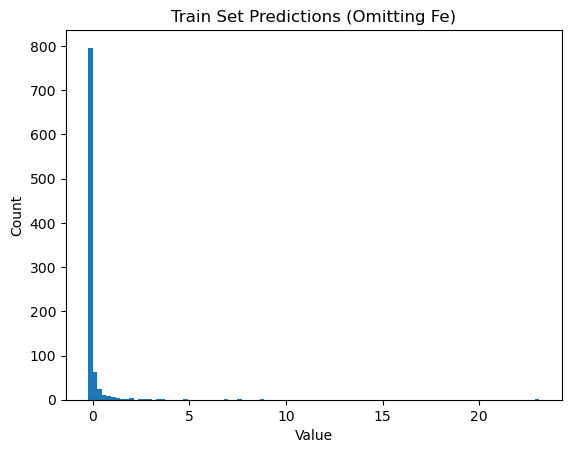

In [17]:
ax = plt.hist(train_df['z_score_err'].values, bins=100)
plt.title('Train Set Predictions (Omitting '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [56]:
#select samples with minimal error
train_subset_df = train_df.nsmallest(num_sample_in_loader, 'z_score_err')
train_subset_df_idx = train_subset_df.index.values.tolist()
train_subset_list = [train_data[i] for i in train_subset_df_idx]
train_subset_dataloader = get_data_loader(train_subset_list, target, workers=4)
train_subset_df.head() #contains the ids of train sub-selected samples

data range 1.31171 -3.24073
Converting to graphs!


100%|██████████| 50/50 [00:00<00:00, 127.01it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[5.614561710069512, -0.008098... -3.04140   0
1   {'lattice_mat': [[4.428712142345245, 0.0938283... -1.15984   1
2   {'lattice_mat': [[6.077481786895317, 0.0, 0.0]... -0.84152   2
3   {'lattice_mat': [[7.542839764249747, 0.1718970... -0.44498   3
4   {'lattice_mat': [[5.382597739169287, 0.0, -0.0... -2.65345   4
5   {'lattice_mat': [[5.341766494740965, 4.8168425... -0.56058   5
6   {'lattice_mat': [[3.413342172498346, 0.0, 0.0]... -1.42034   6
7   {'lattice_mat': [[4.328319117003372, 1.032103e... -1.67055   7
8   {'lattice_mat': [[5.995433144500313, 0.0005096... -0.39732   8
9   {'lattice_mat': [[4.452327579413091, -0.007614... -1.46129   9
10  {'lattice_mat': [[3.8371322574431592, 0.0, 0.0...  0.04698  10
11  {'lattice_mat': [[3.4021647857751227, -3.63769... -3.08561  11
12  {'lattice_mat': [[0.0, 4.897127193355007, 4.89...  0.29936  12
13  {'lattice_mat': [[3.751609782599518, -0.0, -0....  0.28

100%|██████████| 50/50 [00:00<00:00, 2083.24it/s]


,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search,pred_val,err,abs_err,z_score_err
716,JVASP-98452,2,P-1,K2Ca3Si3O10,-3.04140,OptB88vdW,4.228,"{'lattice_mat': [[5.614561710069512, -0.008098...",na,0.0,...,na,na,na,na,mp-1019747,-Ca-K-O-Si,-3.041397,-0.000003,0.000003,-0.227288
906,JVASP-86159,8,Cm,Ca3SiBr2,-1.15984,OptB88vdW,0.000,"{'lattice_mat': [[4.428712142345245, 0.0938283...",na,0.0,...,na,na,0.0,na,mp-568791,-Br-Ca-Si,-1.159848,0.000008,0.000008,-0.227182
219,JVASP-85713,26,Pmc2_1,LiHS,-0.84152,OptB88vdW,3.501,"{'lattice_mat': [[6.077481786895317, 0.0, 0.0]...",na,0.0,...,23.69,5.55,na,na,mp-644419,-H-Li-S,-0.841544,0.000024,0.000024,-0.226805
475,JVASP-5503,2,P-1,TeAuCl7,-0.44498,OptB88vdW,1.466,"{'lattice_mat': [[7.542839764249747, 0.1718970...",20.29,0.0,...,na,na,2.126,na,mp-28330,-Au-Cl-Te,-0.445009,0.000029,0.000029,-0.226706
696,JVASP-97814,62,Pnma,Sn2BF7,-2.65345,OptB88vdW,4.390,"{'lattice_mat': [[5.382597739169287, 0.0, -0.0...",na,0.0,...,na,na,na,na,mp-27430,-B-F-Sn,-2.653481,0.000031,0.000031,-0.226656


In [22]:
#load train subset to dataloader
subset_train_x = []
subset_train_y = []

for i in train_subset_dataloader:
    subset_train_x.append((i[0], i[1]))
    subset_train_y.append(i[2])

## Subselect Test Samples - Most OOD (Maximum Error)

In [23]:
test_df = pd.DataFrame(test_data)
test_df['pred_val'] = model_test_predictions
test_df['err'] = (test_df[target] - test_df['pred_val'])
test_df['abs_err'] = np.abs(test_df[target] - test_df['pred_val'])
test_df['z_score_err'] = (test_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

In [25]:
test_subset_df = test_df.nlargest(num_sample_in_loader, 'z_score_err')
test_subset_df_idx = test_subset_df.index.values.tolist()
test_subset_list = [test_data[i] for i in test_subset_df_idx]
test_subset_dataloader = get_data_loader(test_subset_list, target, workers=4)

data range 1.56755 -2.4227
Converting to graphs!


100%|██████████| 50/50 [00:00<00:00, 125.31it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1   {'lattice_mat': [[0.0, 4.897056811995578, 4.89...  1.53929   1
2   {'lattice_mat': [[4.110215016104089, 0.0, 0.0]... -0.04638   2
3   {'lattice_mat': [[2.848077488322179, 2.8480774... -0.10758   3
4   {'lattice_mat': [[4.1657904284125715, 4.165790... -0.04919   4
5   {'lattice_mat': [[2.920865223038774, 2.9208652... -0.34463   5
6   {'lattice_mat': [[-0.0, 5.137906744010782, 5.1...  1.00634   6
7   {'lattice_mat': [[-0.0, 4.907221750514012, 4.9...  0.85838   7
8   {'lattice_mat': [[3.903902177836003, 0.0, 0.0]... -1.20482   8
9   {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   9
10  {'lattice_mat': [[3.0998966569685593, 0.0, 0.0... -1.88091  10
11  {'lattice_mat': [[8.144256654569737, -0.0, 0.0... -1.34337  11
12  {'lattice_mat': [[4.811567551604352, 0.0, 0.0]... -1.96675  12
13  {'lattice_mat': [[-0.0, 3.24316049942265, 3.24...  0.14

100%|██████████| 50/50 [00:00<00:00, 2272.72it/s]


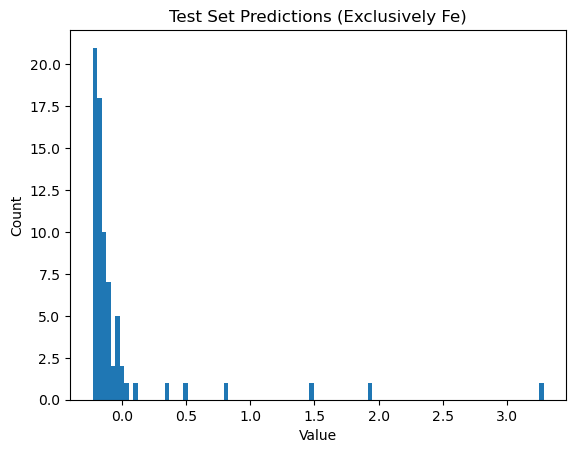

In [26]:
ax = plt.hist(test_df['z_score_err'].values, bins=100,)
plt.title('Test Set Predictions (Exclusively '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

# Getting the Hessian Eigenvectors

In [27]:
from src import botcher_hessian as hess
from src import botcher_utilities as util

The following functions are copy-pasted from Botcher implementation.  I put them here so that I could debug more easily.

In [28]:
def npvec_to_tensorlist(vec, params):
    """ Convert a numpy vector to a list of tensor with the same dimensions as params

        Args:
            vec: a 1D numpy vector
            params: a list of parameters from net

        Returns:
            rval: a list of tensors with the same shape as params
    """
    loc = 0
    rval = []
    for p in params:
        numel = p.data.numel()
        rval.append(torch.from_numpy(vec[loc:loc+numel]).view(p.data.shape).float())
        loc += numel
    assert loc == vec.size, 'The vector has more elements than the net has parameters'
    return rval


def gradtensor_to_npvec(net, all_params=True):
    """ Extract gradients from net, and return a concatenated numpy vector.

        Args:
            net: trained model
            all_params: If all_params, then gradients w.r.t. BN parameters and bias
            values are also included. Otherwise only gradients with dim > 1 are considered.

        Returns:
            a concatenated numpy vector containing all gradients
    """
    filter = lambda p: all_params or len(p.data.size()) > 1
    return np.concatenate([p.grad.data.cpu().numpy().ravel() for p in net.parameters() if filter(p)])


def eval_hess_vec_prod(vec, params, net, loss_func, inputs_dataloader, outputs, use_cuda=False):
    from torch.autograd import Variable
    """
    Evaluate product of the Hessian of the loss function with a direction vector "vec".
    The product result is saved in the grad of net.

    Args:
        vec: a list of tensor with the same dimensions as "params".
        params: the parameter list of the net (ignoring biases and BN parameters).
        net: model with trained parameters.
        criterion: loss function.
        inputs: nn inputs.
        outputs: desired nn outputs.
        use_cuda: use GPU.
    """

    if use_cuda:
        net.cuda()
        vec = [v.cuda() for v in vec]

    net.eval()
    net.zero_grad() # clears grad for every parameter in the net
    
    ### OG IMPLEMENTATION
    # pred_outputs = net(inputs.unsqueeze(-1)).flatten()
    # pred_outputs = net(inputs_dataloader)
    loss = torch.tensor(0.0).to(device)
    for _, i in tqdm(enumerate(inputs_dataloader), total=len(inputs_dataloader)):
        pred_outputs = net((i[0].to(device), i[1].to(device)))
        # pred_outputs = np.expand_dims(pred_outputs.cpu().detach().numpy(), axis=0)[0]
        outputs = i[2].to(device)
        loss = torch.add(loss, loss_func(pred_outputs,outputs))
    
    loss = loss/len(inputs_dataloader)
    grad_f = torch.autograd.grad(loss, inputs=params, create_graph=True, allow_unused=True)

    # Compute inner product of gradient with the direction vector
    prod = Variable(torch.zeros(1)).type(type(grad_f[0].data))

    #for i in range(len(vec)):
    tmp = []
    for i in range(len(vec)):
        if (grad_f[i] is not None) and (vec[i] is not None):
            tmp.append((grad_f[i].to(device) * vec[i].to(device)).cpu().sum())
    prod =+ sum(tmp)
    # prod += sum([(grad_f[i] * vec[i]).cpu().sum() for i in range(len(vec))])

    # Compute the Hessian-vector product, H*v
    # prod.backward() computes dprod/dparams for every parameter in params and
    # accumulate the gradients into the params.grad attributes
    prod.backward()
    

In [29]:
def min_max_hessian_eigs(net, inputs, outputs, criterion, rank=0, use_cuda=False, verbose=False, all_params=True):
    from scipy.sparse.linalg import LinearOperator, eigsh
    import time
    """
        Compute the largest and the smallest eigenvalues of the Hessian marix.

        Args:
            net: the trained model.
            inputs: nn inputs.
            outputs: desired nn outputs.
            criterion: loss function.
            rank: rank of the working node.
            use_cuda: use GPU
            verbose: print more information
            all_params: use all nn parameters

        Returns:
            maxeig: max eigenvalue
            mineig: min eigenvalue
            hess_vec_prod.count: number of iterations for calculating max and min eigenvalues
    """
    
    if all_params:
        params = [p for p in net.parameters()]
    else:
        params = [p for p in net.parameters() if len(p.size()) > 1]
        
    N = sum(p.numel() for p in params)

    def hess_vec_prod(vec):
        hess_vec_prod.count += 1  # simulates a static variable
        vec = npvec_to_tensorlist(vec, params)
        start_time = time.time()
        eval_hess_vec_prod(vec, params, net, criterion, inputs, outputs, use_cuda)
        prod_time = time.time() - start_time
        if verbose and rank == 0: print("Iter: %d  time: %f" % (hess_vec_prod.count, prod_time))
        return gradtensor_to_npvec(net,all_params)
        
    hess_vec_prod.count = 0
    if verbose and rank == 0: print("Rank %d: computing max eigenvalue" % rank)

    A = LinearOperator((N, N), matvec=hess_vec_prod)
  
    eigvals, eigvecs = eigsh(A, k=1, which='LM', tol=1e-2)
    maxeig = eigvals[0]
    maxeigvec = eigvecs
    if verbose and rank == 0: print('max eigenvalue = %f' % maxeig)

    # If the largest eigenvalue is positive, shift matrix so that any negative eigenvalue is now the largest
    # We assume the smallest eigenvalue is zero or less, and so this shift is more than what we need
    shift = maxeig*1.0
    def shifted_hess_vec_prod(vec):
        return hess_vec_prod(vec) - shift*vec

    if verbose and rank == 0: print("Rank %d: Computing shifted eigenvalue" % rank)

    A = LinearOperator((N, N), matvec=shifted_hess_vec_prod)
    eigvals, eigvecs = eigsh(A, k=1, which='LM', tol=1e-2)
    eigvals = eigvals + shift
    mineig = eigvals[0]
    mineigvec = eigvecs
    if verbose and rank == 0: print('min eigenvalue = ' + str(mineig))

    if maxeig <= 0 and mineig > 0:
        maxeig, mineig = mineig, maxeig
        maxeig, mineig = mineigvec, maxeigvec

    return maxeig, mineig, maxeigvec, mineigvec, hess_vec_prod.count

In [30]:
### Defaults from OG implementation
loss_func = torch.nn.MSELoss()
func = copy.deepcopy(model)
og_params = [i[1] for i in func.named_parameters() if len(i[1].size()) > 1]
og_layer_names = [i[0] for i in func.named_parameters() if len(i[1].size())>1]

This next cell calculates the eigenvectors, and can take considerable time (upwards of 40 minutes)

here, we are computing the hessian eigenvectors using 3(or more) samples that 1. do not contain Fe, 2. is well predicted by the model (defined by existing model weights)

then, we perturb the model such that the rate of loss increase would increase or we perturb the model such that the rate of loss increase would be constant

we then test these perturbed model's performance on the same 3 samples that it had been predicting well to construct the loss land scape.

- on the other hand, we will be picking samples that do not contain Fe and was not well predicted by the original model. they will not be involved in the hessian computation, so the perturbation has nothing to do with them. we will then test the perturbed model's performance on these samples

hypothesis (need to be validated):

perturbing in the direction of max eigenvector should increase/decress the loss by a lot (but that would be true for first derivative??? ask)

perturbing in the direction of min eigenvector should not increase/decress the loss by a lot since it is the flattest direction




- also, the choice of loss function is involved twice, 1. when we are choosing the samples; 2. when we are computing the hessian; 3. when we are visualizing the loss landscape

In [31]:
maxeig, mineig, maxeigvec, mineigvec, num_iter = min_max_hessian_eigs(
    func, train_subset_dataloader, subset_train_y, loss_func, all_params=False
    )

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\EthanH24\anaconda3\envs\losslandscapefeb8gpu4\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 50/50 [00:02<00:00, 23.53it/s]


we found two directions of steepest and flattest curvature, the eigenvectors have unit length

In [32]:
print(maxeig, mineig)

48.10708 -9.479919071964105e-10


In [33]:
norm = np.linalg.norm(maxeigvec)
print(f"The Euclidean norm of the eigenvector is: {norm}")

The Euclidean norm of the eigenvector is: 1.0000001192092896


In [35]:
def unpack_tensors_to_1d(tensor_list):
    """Unpack a list of 2D tensors into a 1D NumPy array.

    Args:
        tensor_list: A list of 2D PyTorch tensors.

    Returns:
        A 1D NumPy array containing all elements from the tensors.
    """
    # Flatten each tensor, detach from the computation graph, move to CPU, and convert to a NumPy array
    flattened_arrays = [tensor.detach().cpu().flatten().numpy() for tensor in tensor_list]
    
    # Concatenate all flattened arrays into a single 1D array
    result = np.concatenate(flattened_arrays)
    
    return result

# Now you can call the function without encountering the TypeError
unpacked_array = unpack_tensors_to_1d(og_params)
norm = np.linalg.norm(unpacked_array)
print(f"The Euclidean norm of the weights is: {norm}")


The Euclidean norm of the weights is: 520.29345703125


# Formatting as Two New Models

create two models with weights being the two most dominant hessian eigenvector and save to local path

In [45]:
max_model_wts = hess.npvec_to_tensorlist(maxeigvec, og_params)
min_model_wts = hess.npvec_to_tensorlist(mineigvec, og_params)

model_eig_max = copy.deepcopy(func)
model_eig_min = copy.deepcopy(func)

In [46]:
# There will be some incompatible keys due to the batch norm values
# the original batch norm values will be retained
model_eig_max = force_wts_into_model(og_layer_names, max_model_wts, model_eig_max,  model_wt_dict)
model_eig_min = force_wts_into_model(og_layer_names, min_model_wts, model_eig_min,  model_wt_dict)

_IncompatibleKeys(missing_keys=['atom_embedding.layer.1.running_mean', 'atom_embedding.layer.1.running_var', 'edge_embedding.0.centers', 'edge_embedding.1.layer.1.running_mean', 'edge_embedding.1.layer.1.running_var', 'edge_embedding.2.layer.1.running_mean', 'edge_embedding.2.layer.1.running_var', 'angle_embedding.0.centers', 'angle_embedding.1.layer.1.running_mean', 'angle_embedding.1.layer.1.running_var', 'angle_embedding.2.layer.1.running_mean', 'angle_embedding.2.layer.1.running_var', 'alignn_layers.0.node_update.bn_edges.running_mean', 'alignn_layers.0.node_update.bn_edges.running_var', 'alignn_layers.0.node_update.bn_nodes.running_mean', 'alignn_layers.0.node_update.bn_nodes.running_var', 'alignn_layers.0.edge_update.bn_edges.running_mean', 'alignn_layers.0.edge_update.bn_edges.running_var', 'alignn_layers.0.edge_update.bn_nodes.running_mean', 'alignn_layers.0.edge_update.bn_nodes.running_var', 'alignn_layers.1.node_update.bn_edges.running_mean', 'alignn_layers.1.node_update.bn_e

In [47]:
torch.save(model_eig_max.state_dict(), 'model_eig_max.pt')
torch.save(model_eig_min.state_dict(), 'model_eig_min.pt')

inspecting the original weights and hessian eigenvector model

In [48]:
og_params[0][0][:4]

tensor([-0.0489, -0.0350,  0.1071, -0.1211], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [49]:
maxeigvec[:4].flatten()

array([1.3937840e-05, 5.1789698e-06, 1.6494187e-04, 0.0000000e+00],
      dtype=float32)

In [50]:
max_model_wts[0][0][:4]

tensor([1.3938e-05, 5.1790e-06, 1.6494e-04, 0.0000e+00])

In [51]:
max_model_params = [i[1] for i in model_eig_max.named_parameters() if len(i[1].size()) > 1]
max_model_params[0]

Parameter containing:
tensor([[ 1.3938e-05,  5.1790e-06,  1.6494e-04,  ...,  3.7632e-05,
          1.5899e-05,  0.0000e+00],
        [ 1.1868e-05,  7.6569e-06, -2.0781e-05,  ..., -1.9890e-05,
         -8.2938e-07,  0.0000e+00],
        [ 1.3115e-06, -4.7240e-06, -1.3706e-05,  ..., -1.2141e-05,
          2.5079e-06,  0.0000e+00],
        ...,
        [ 3.1603e-05,  5.8877e-06,  5.8690e-06,  ..., -2.1886e-05,
          1.2498e-06,  0.0000e+00],
        [ 6.6453e-06,  2.4982e-05,  7.2249e-05,  ...,  5.0897e-05,
          2.1233e-05,  0.0000e+00],
        [ 4.5978e-06,  5.8054e-05, -2.7311e-05,  ..., -4.1944e-06,
          4.1606e-05,  0.0000e+00]], device='cuda:0', requires_grad=True)